In [28]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL.Image as Image
import os
import glob
import torchvision.models as models
import copy
import time

In [29]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


# Network

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(64*4*4*4*4, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
                nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.convolutional(x)

        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)

        return x


# Hotdog class

In [31]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

# Train function

In [41]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, criterion, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = criterion(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()

        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(criterion(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
            
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

    return out_dict

# Visualize the model predictions function

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Load and show some images

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Resize(256), 
                            transforms.CenterCrop(224), 
                            transforms.ToTensor(),
                            normalize
                            ])

In [8]:
batch_size = 64

trainset = Hotdog_NotHotdog(train=True, transform=trans)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=trans)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

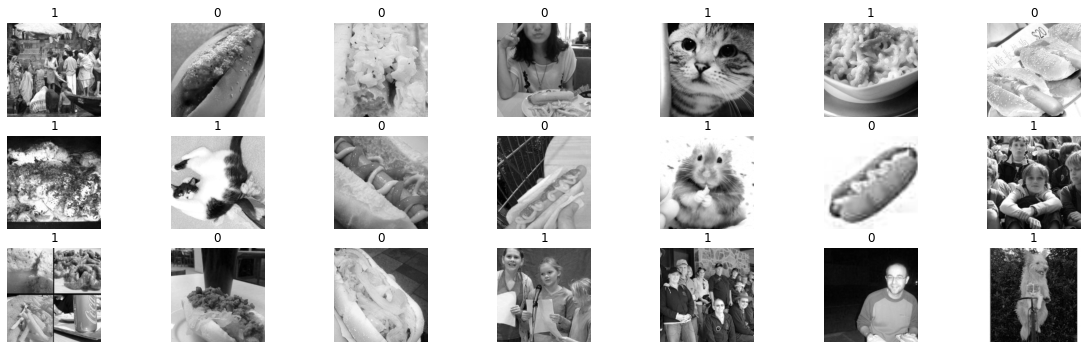

In [9]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

# Train model and try data augmentation and different optimizers

In [ ]:
size = 128
aug_transforms = [
    transforms.Compose([transforms.Resize((size, size)), 
                        transforms.ToTensor()]),
    transforms.Compose([transforms.Resize((size*2, size*2)),
                        transforms.RandomCrop(size), 
                        transforms.ToTensor()]),                        
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor()]),  
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomRotation((-45, 45)), 
                        transforms.ToTensor()]),   
    transforms.Compose([transforms.Resize((size, size)), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    transforms.Compose([transforms.Resize((size*2, size*2)),
                        transforms.RandomCrop(size), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),                      
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomRotation((-45, 45)), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
]



In [ ]:
model_results = {
    'adam': [],
    'sgd': []
    }
batch_size = 64
for trans in aug_transforms:
    trainset = Hotdog_NotHotdog(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = Hotdog_NotHotdog(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

    model = Net()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = F.nll_loss()
    model_results['adam'].append(train(model, optimizer, criterion))

for trans in aug_transforms:
    trainset = Hotdog_NotHotdog(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = Hotdog_NotHotdog(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

    model = Net()
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    criterion = F.nll_loss()
    model_results['sgd'].append(train(model, optimizer, criterion))

In [ ]:
best_model = {
    'optimizer': '',
    'id': -1,
    'accuracy': 0
}

for model_id in range(len(model_results['adam'])):
    sgd_acc = model_results['sgd'][model_id]['test_acc'][len(model_results['sgd'][model_id])]
    adam_acc = model_results['adam'][model_id]['test_acc'][len(model_results['sgd'][model_id])]
    if sgd_acc > adam_acc:
        if sgd_acc > best_model['accuracy']:
            best_model['optimizer'] = 'sgd'
            best_model['id'] = model_id
            best_model['accuracy'] = sgd_acc
    else:
        best_model['optimizer'] = 'adam'
        best_model['id'] = model_id
        best_model['accuracy'] = adam_acc
    print('sgd:', model_results['sgd'][model_id]['test_acc'][len(model_results['sgd'][model_id])])
    print('adam:', model_results['adam'][model_id]['test_acc'][len(model_results['sgd'][model_id])])
    print()


In [ ]:
print(best_model)
plt.plot(range(1,11), model_results['sgd'][best_model['id']]['test_acc'], color='red', linestyle='dashed', linewidth=2)
plt.plot(range(1,11), model_results['sgd'][best_model['id']]['train_acc'], color='red', linewidth=2)
plt.plot(range(1,11), model_results['adam'][best_model['id']]['test_acc'], color='blue', linestyle='dashed', linewidth=2)
plt.plot(range(1,11), model_results['adam'][best_model['id']]['train_acc'], color='blue', linewidth=2)
plt.legend(('Test accuracy SGG','Train eror SGG','Test error ADAM','Train eror ADAM'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

# Transfer Learning

In [33]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Resize(256), 
                            transforms.CenterCrop(224), 
                            transforms.ToTensor(),
                            normalize
                            ])

In [34]:
batch_size = 64

trainset = Hotdog_NotHotdog(train=True, transform=trans)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=trans)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [35]:
# load model and observe its fully-connected (output) layer
resnet_152 = models.resnet152(pretrained=True)
resnet_152.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [36]:
num_ftrs = resnet_152.fc.in_features
out_features = resnet_152.fc.out_features
print("# of input features:", num_ftrs)
print("# of output features:", out_features)

# of input features: 2048
# of output features: 1000


In [43]:
# freeze all the layers except from the last one
# Parameters of newly constructed modules have requires_grad=True by default
for param in resnet_152.parameters():
    param.requires_grad = False

# adjust fully connected layer to have just 2 features output (binary classification)
resnet_152.fc = nn.Linear(num_ftrs, 2)

# transfer model to gpu
resnet_152 = resnet_152.to(device)

# add loss function
criterion = nn.CrossEntropyLoss()

# Observe that all only the final layer parameters are being optimized
# optimizer_ft = torch.optim.SGD(resnet_152.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(resnet_152.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [45]:
# train model
transfer_learning_results = train(resnet_152, optimizer_ft, criterion, num_epochs=7)

  0%|          | 0/7 [00:00<?, ?epoch/s]

Epoch 0/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.076	 test: 0.133	 Accuracy train: 97.3%	 test: 94.6%
Epoch 1/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.058	 test: 0.140	 Accuracy train: 98.0%	 test: 94.3%
Epoch 2/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.061	 test: 0.146	 Accuracy train: 98.0%	 test: 94.4%
Epoch 3/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.061	 test: 0.132	 Accuracy train: 97.6%	 test: 94.3%
Epoch 4/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.049	 test: 0.132	 Accuracy train: 98.5%	 test: 94.4%
Epoch 5/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.056	 test: 0.133	 Accuracy train: 98.1%	 test: 94.0%
Epoch 6/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.062	 test: 0.138	 Accuracy train: 97.8%	 test: 94.6%
